# Boxing DQN Assignment - Deep Q-Learning Implementation

This notebook implements Deep Q-Learning for Atari Boxing using five independent experiments to test different hyperparameters. Each experiment evaluates the impact of varying learning rate (alpha), discount factor (gamma), exploration parameters, and exploration policy.

## Training Configuration

- **Training steps per experiment:** 500,000 (approximately 1,120 episodes)
- **Test episodes:** 20
- **Results:** Automatically saved to Google Drive for persistence across sessions


## Step 1: Mount Google Drive

Mount Google Drive for persistent storage across sessions. All trained models and results save here automatically, allowing multi-day training.

**Important:** Run this cell at the start of every session.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

import os
from datetime import datetime

# Create organized directory structure
base_dir = '/content/drive/MyDrive/boxing_dqn_assignment'
weights_dir = os.path.join(base_dir, 'weights')
results_dir = os.path.join(base_dir, 'results')
plots_dir = os.path.join(base_dir, 'plots')

for directory in [base_dir, weights_dir, results_dir, plots_dir]:
    os.makedirs(directory, exist_ok=True)

# Check existing progress
existing_results = [f for f in os.listdir(results_dir)
                   if f.endswith('.json') and 'all_results' not in f]
print(f"Previously completed experiments: {len(existing_results)}/5")
if existing_results:
    for f in sorted(existing_results):
        print(f"  - {f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Previously completed experiments: 6/5
  - 01_baseline.json
  - 02_moderate_lr.json
  - 03_gamma_0.8.json
  - 04_moderate_epsilon.json
  - 05_boltzmann_policy.json
  - test_boltzmann_policy.json


## Step 2: Install Dependencies

Installing required libraries:
- **Gymnasium:** Modern reinforcement learning environment library
- **Stable-Baselines3:** Production-ready RL algorithm implementations
- **ALE (Arcade Learning Environment):** Atari 2600 game emulator
- **OpenCV:** Image processing for frame preprocessing

Run at the start of each new Colab session (packages reset when runtime disconnects).

In [14]:
!pip install -q gymnasium "gymnasium[atari,accept-rom-license]" ale-py stable-baselines3[extra] opencv-python
!apt-get install -y swig cmake > /dev/null 2>&1

## Step 3: Import Libraries

Import all required libraries and register ALE Atari environments. The `gym.register_envs(ale_py)` call is critical for accessing Boxing-v5.


In [15]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Register ALE environments (enables ALE/Boxing-v5)
import ale_py
gym.register_envs(ale_py)

## Environment Specification and Analysis

This section analyzes the Boxing-v5 environment structure and explains why Deep Q-Learning uses a neural network instead of a traditional Q-table.

### State Space, Action Space, and Q-Function Approximation

In [16]:
base_env = gym.make('ALE/Boxing-v5')
print(f"Action Space: {base_env.action_space.n} discrete actions")
print(f"Raw Observation: {base_env.observation_space.shape}")
print(f"After preprocessing: 84×84×4 (grayscale, resized, stacked)")
print(f"\nQ-table would be: 256^(84×84×4) × 18 ≈ 10^67,000 (intractable)")
print(f"DQN solution: Neural network function approximator")
base_env.close()

Action Space: 18 discrete actions
Raw Observation: (210, 160, 3)
After preprocessing: 84×84×4 (grayscale, resized, stacked)

Q-table would be: 256^(84×84×4) × 18 ≈ 10^67,000 (intractable)
DQN solution: Neural network function approximator


### Reward Structure

- **+1**: Agent lands punch
- **-1**: Agent takes punch  
- **0**: No contact

Native Boxing-v5 rewards. Sparse signal makes learning challenging.

## Custom Atari Preprocessing Wrappers

Custom wrappers for Atari frame preprocessing:

1. **AtariPreprocessing**: Converts to grayscale, resizes, implements frame skipping
2. **FrameStack**: Stacks consecutive frames to capture motion/velocity

These are standard preprocessing steps for Atari DQN as described in Mnih et al. (2015) "Human-level control through deep reinforcement learning"

### Why These Preprocessing Steps?

- **Grayscale conversion:** Reduces dimensionality from 210×160×3 to 84×84×1
- **Resize to 84×84:** Reduces computation while preserving essential game information
- **Frame skipping:** Action repeated for 4 frames, increases training speed
- **Frame stacking:** 4 consecutive frames stacked to capture temporal information (motion, velocity)

This reduces the state space from 256^(210×160×3) ≈ 10^120,000 to a manageable representation.

In [17]:
from gymnasium import Wrapper
from gymnasium.spaces import Box
import cv2

class AtariPreprocessing(Wrapper):
    """
    Preprocess Atari frames for DQN input.

    Converts RGB frames to grayscale and resizes to 84×84.
    Implements frame skipping where action is repeated for multiple frames.
    """
    def __init__(self, env, frame_skip=4, screen_size=84):
        super().__init__(env)
        self.frame_skip = frame_skip
        self.screen_size = screen_size

        self.observation_space = Box(
            low=0, high=255,
            shape=(screen_size, screen_size),
            dtype=np.uint8
        )

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        return self._process_frame(obs), info

    def step(self, action):
        total_reward = 0.0

        # Repeat action for frame_skip frames
        for _ in range(self.frame_skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward

            if terminated or truncated:
                break

        return self._process_frame(obs), total_reward, terminated, truncated, info

    def _process_frame(self, frame):
        """Convert RGB to grayscale and resize"""
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (self.screen_size, self.screen_size),
                            interpolation=cv2.INTER_AREA)
        return resized


class FrameStack(Wrapper):
    """
    Stack the last n frames together.

    Allows agent to perceive motion and velocity by comparing
    consecutive frames. Critical for understanding game dynamics.
    """
    def __init__(self, env, n_frames=4):
        super().__init__(env)
        self.n_frames = n_frames
        self.frames = []

        # Update observation space for stacked frames
        low = np.repeat(env.observation_space.low[..., np.newaxis], n_frames, axis=-1)
        high = np.repeat(env.observation_space.high[..., np.newaxis], n_frames, axis=-1)
        self.observation_space = Box(low=low, high=high, dtype=env.observation_space.dtype)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Initialize stack with first frame repeated
        self.frames = [obs] * self.n_frames
        return self._get_obs(), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.frames.append(obs)
        # Keep only last n frames
        self.frames = self.frames[-self.n_frames:]
        return self._get_obs(), reward, terminated, truncated, info

    def _get_obs(self):
        """Stack frames along last dimension"""
        return np.stack(self.frames, axis=-1)

## Episode Tracking Callback

Tracks episode-level statistics during training for later analysis. Records total reward and length of each episode.

In [18]:
class EpisodeTracker(BaseCallback):
    """
    Callback to track episode statistics during training.

    Attributes:
        episodes: Total number of completed episodes
        episode_rewards: List of cumulative rewards per episode
        episode_lengths: List of steps per episode
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episodes = 0
        self.episode_rewards = []
        self.episode_lengths = []
        self.current_reward = 0
        self.current_length = 0

    def _on_step(self) -> bool:
        """Called after each environment step"""
        self.current_reward += self.locals['rewards'][0]
        self.current_length += 1

        if self.locals['dones'][0]:
            # Episode ended - save statistics
            self.episodes += 1
            self.episode_rewards.append(self.current_reward)
            self.episode_lengths.append(self.current_length)

            # Reset for next episode
            self.current_reward = 0
            self.current_length = 0

        return True


## Helper Functions

Core functions for environment creation and experiment execution.

- `create_environment()`: Creates preprocessed Boxing environment
- `train_experiment()`: Trains one experiment configuration and saves results

In [19]:
def create_environment():
    """
    Create Boxing environment with standard preprocessing.

    Returns:
        Gym environment with grayscale conversion, resizing,
        frame skipping, and frame stacking applied.
    """
    base_env = gym.make('ALE/Boxing-v5')
    env = AtariPreprocessing(base_env, frame_skip=4, screen_size=84)
    env = FrameStack(env, n_frames=4)
    return env


def train_experiment(experiment_name, config, training_steps, test_episodes):
    """
    Train DQN agent for one experiment configuration.

    Args:
        experiment_name: Unique identifier for this experiment
        config: Dictionary of hyperparameters
        training_steps: Number of environment steps for training
        test_episodes: Number of episodes for evaluation

    Returns:
        Dictionary containing training and testing metrics

    The function handles:
    - Environment creation
    - Model building with specified hyperparameters
    - Training with episode tracking
    - Testing/evaluation
    - Saving results to Google Drive
    - Error handling
    """

    print(f"\n{experiment_name}")
    print(f"Configuration: {config}")
    print(f"Start time: {datetime.now().strftime('%H:%M:%S')}")

    # Create environment
    env = create_environment()

    # Extract hyperparameters with defaults
    lr = config.get('learning_rate', 1e-4)
    gamma = config.get('gamma', 0.99)
    exploration_fraction = config.get('exploration_fraction', 0.8)
    exploration_final = config.get('exploration_final', 0.01)

    # Build DQN model with Stable-Baselines3
    model = DQN(
        policy='CnnPolicy',  # CNN architecture for image inputs
        env=env,
        learning_rate=lr,
        buffer_size=100000,  # Experience replay buffer size
        learning_starts=10000,  # Random actions before learning begins
        batch_size=32,
        gamma=gamma,  # Discount factor in Bellman equation
        train_freq=4,  # Train every 4 steps
        gradient_steps=1,
        target_update_interval=1000,  # Update target network every 1000 steps
        exploration_fraction=exploration_fraction,
        exploration_initial_eps=1.0,
        exploration_final_eps=exploration_final,
        verbose=0,
        device='auto'  # Automatically use GPU if available
    )

    # Train model with episode tracking
    tracker = EpisodeTracker()
    start_time = time.time()

    try:
        model.learn(total_timesteps=training_steps, callback=tracker, progress_bar=True)
        training_successful = True
    except Exception as e:
        print(f"Training error: {e}")
        env.close()
        return None

    training_time = time.time() - start_time

    # Evaluate trained model
    test_rewards = []
    test_steps = []

    for episode in range(test_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        episode_steps = 0

        while not done:
            # Use deterministic policy for evaluation (no exploration)
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            episode_steps += 1

            # Safety limit to prevent infinite episodes
            if episode_steps > 10000:
                break

        test_rewards.append(episode_reward)
        test_steps.append(episode_steps)

    # Compile results
    results = {
        'experiment': experiment_name,
        'config': config,
        'training': {
            'steps': training_steps,
            'episodes': tracker.episodes,
            'time_minutes': training_time / 60,
            'time_hours': training_time / 3600,
            'avg_reward': float(np.mean(tracker.episode_rewards)) if tracker.episode_rewards else 0.0,
            'all_rewards': [float(r) for r in tracker.episode_rewards]
        },
        'testing': {
            'episodes': test_episodes,
            'mean_reward': float(np.mean(test_rewards)),
            'std_reward': float(np.std(test_rewards)),
            'min_reward': float(np.min(test_rewards)),
            'max_reward': float(np.max(test_rewards)),
            'mean_steps': float(np.mean(test_steps)),
            'all_rewards': [float(r) for r in test_rewards],
            'all_steps': [int(s) for s in test_steps]
        }
    }

    # Save model and results to Google Drive
    try:
        weight_file = os.path.join(weights_dir, f'{experiment_name}.zip')
        model.save(weight_file)

        result_file = os.path.join(results_dir, f'{experiment_name}.json')
        with open(result_file, 'w') as f:
            json.dump(results, f, indent=4)

        print(f"Completed in {training_time/60:.1f} minutes")
        print(f"Training episodes: {tracker.episodes} | Test reward: {results['testing']['mean_reward']:.2f} +/- {results['testing']['std_reward']:.2f}")
        print(f"Saved to Drive: {experiment_name}.zip, {experiment_name}.json")

    except Exception as e:
        print(f"Error saving results: {e}")

    env.close()
    return results

## Training Configuration

Configure training parameters for all experiments.

**Parameters:**
- Training steps: 500,000 per experiment
- Test episodes: 20

These parameters can be adjusted based on available time and desired training depth.

In [20]:
# Configuration parameters
TRAINING_STEPS = 500000
TEST_EPISODES = 20

print(f"Configuration set:")
print(f"  Training steps per experiment: {TRAINING_STEPS:,}")
print(f"  Test episodes: {TEST_EPISODES}")

Configuration set:
  Training steps per experiment: 500,000
  Test episodes: 20


## Experiment 1: Baseline

Establishes baseline performance using standard DQN hyperparameters. This serves as the reference point for all other experiments.

### Configuration
- **Learning rate (alpha):** 1e-4 (standard for Adam optimizer with neural networks)
- **Gamma:** 0.99 (high discount factor, values rewards up to 100 steps in future)
- **Epsilon decay:** Linear from 1.0 to 0.01 over 80% of training steps

### Purpose
Provides baseline metrics to compare against when testing different hyperparameter values.


In [ ]:
config1 = {
    'learning_rate': 1e-4,
    'gamma': 0.99,
    'exploration_fraction': 0.8,
    'exploration_final': 0.01
}

results1 = train_experiment('01_baseline', config1, TRAINING_STEPS, TEST_EPISODES)


01_baseline
Configuration: {'learning_rate': 0.0001, 'gamma': 0.99, 'exploration_fraction': 0.8, 'exploration_final': 0.01}
Start time: 01:50:00


Output()

Completed in 61.3 minutes
Training episodes: 1118 | Test reward: 22.60 +/- 8.48
Saved to Drive: 01_baseline.zip, 01_baseline.json


## Experiment 2: Moderate Learning Rate (Alpha Test)

Tests impact of increased learning rate on convergence speed and stability.

### Hypothesis

Moderately higher learning rate (2.5x increase) may accelerate learning while maintaining stability. This tests the alpha parameter in the Bellman equation.

### Configuration

- **Learning rate:** 2.5e-4 (2.5x higher than baseline)
- **All other parameters:** Same as baseline

### Why 2.5e-4 Instead of Higher?

Initial testing with 1e-3 (10x increase) caused training instability with episodes taking 5x longer. The moderate increase to 2.5e-4 provides a reasonable test of alpha's impact while maintaining training stability.


In [ ]:
config2 = {
    'learning_rate': 2.5e-4,
    'gamma': 0.99,
    'exploration_fraction': 0.8,
    'exploration_final': 0.01
}

results2 = train_experiment('02_moderate_lr', config2, TRAINING_STEPS, TEST_EPISODES)



02_moderate_lr
Configuration: {'learning_rate': 0.00025, 'gamma': 0.99, 'exploration_fraction': 0.8, 'exploration_final': 0.01}
Start time: 18:23:59


Output()

Completed in 56.2 minutes
Training episodes: 1118 | Test reward: 1.15 +/- 5.96
Saved to Drive: 02_moderate_lr.zip, 02_moderate_lr.json


## Experiment 3: Gamma = 0.8 (Discount Factor Test)

Tests lower discount factor as specified in assignment example parameters.

### Hypothesis
Lower gamma (0.8 vs 0.99) emphasizes immediate rewards. In fast-paced Boxing where rewards are frequent (+1/-1 per punch), focusing on immediate rewards may improve performance.

### Bellman Equation Context
The discount factor gamma controls the time horizon:
- gamma = 0.8: Values rewards approximately 5 steps ahead
- gamma = 0.99: Values rewards approximately 100 steps ahead

### Configuration
- **Gamma:** 0.8 (assignment parameter value)
- All other parameters identical to baseline

### Assignment Requirement
Tests "at least one additional value for gamma" in the Bellman equation.

In [ ]:
config3 = {
    'learning_rate': 1e-4,
    'gamma': 0.8,
    'exploration_fraction': 0.8,
    'exploration_final': 0.01
}

results3 = train_experiment('03_gamma_0.8', config3, TRAINING_STEPS, TEST_EPISODES)


03_gamma_0.8
Configuration: {'learning_rate': 0.0001, 'gamma': 0.8, 'exploration_fraction': 0.8, 'exploration_final': 0.01}
Start time: 04:03:49


Output()

Completed in 62.0 minutes
Training episodes: 1124 | Test reward: 15.75 +/- 14.19
Saved to Drive: 03_gamma_0.8.zip, 03_gamma_0.8.json


## Experiment 4: Faster Epsilon Decay (Exploration Test)

Tests alternative exploration schedule with different minimum epsilon and decay rate.

### Hypothesis

Moderate reduction in exploration (decay to 5% instead of 1%) with slightly faster schedule may improve training efficiency without sacrificing exploration adequacy.

### Configuration

- **Exploration fraction:** 0.6 (decay over 60% of training vs 80% baseline)
- **Final epsilon:** 0.05 (maintains 5% exploration vs 1% baseline)
- **Effect:** Reaches 5% exploration at 300k steps vs baseline's 1% at 400k steps

### Why These Parameters?

Initial testing with exploration_final=0.001 caused pathological behavior with 69-hour projected training time due to insufficient exploration. The moderate parameters (final=0.05, fraction=0.6) balance faster convergence with adequate exploration.

In [ ]:
config4 = {
    'learning_rate': 1e-4,
    'gamma': 0.99,
    'exploration_fraction': 0.6,
    'exploration_final': 0.05
}

results4 = train_experiment('04_moderate_epsilon', config4, TRAINING_STEPS, TEST_EPISODES)



04_moderate_epsilon
Configuration: {'learning_rate': 0.0001, 'gamma': 0.99, 'exploration_fraction': 0.6, 'exploration_final': 0.05}
Start time: 21:47:56


Output()

Completed in 54.2 minutes
Training episodes: 1118 | Test reward: 26.25 +/- 10.81
Saved to Drive: 04_moderate_epsilon.zip, 04_moderate_epsilon.json


## Experiment 5: Boltzmann Policy (Alternative to Epsilon-Greedy)

Tests Deep Q-Learning with Boltzmann (softmax) exploration instead of epsilon-greedy.

### Policy Comparison

**Epsilon-Greedy:**
- With probability ε: random action
- With probability 1-ε: best action (argmax Q)

**Boltzmann/Softmax:**
- Probabilistic selection based on Q-values
- P(a|s) = exp(Q(s,a)/τ) / Σ exp(Q(s,a')/τ)
- Temperature τ controls exploration

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback, CallbackList
import numpy as np
import torch
import os
import time
from datetime import datetime
import json

class BoltzmannExplorationCallback(BaseCallback):
    def __init__(self, initial_temp=2.0, final_temp=0.1, decay_steps=400000):
        super().__init__()
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.decay_steps = decay_steps
        self.current_step = 0

    def get_temperature(self):
        if self.current_step >= self.decay_steps:
            return self.final_temp
        ratio = self.current_step / self.decay_steps
        return self.initial_temp - (self.initial_temp - self.final_temp) * ratio

    def _on_step(self) -> bool:
        self.current_step += 1
        return True

    def predict_boltzmann(self, model, obs):
        obs_tensor = model.policy.obs_to_tensor(obs)[0]
        model.policy.q_net.eval()
        with torch.no_grad():
            q_values = model.policy.q_net(obs_tensor).cpu().numpy()[0]
        model.policy.q_net.train()
        temp = self.get_temperature()
        exp_q = np.exp((q_values - np.max(q_values)) / temp)
        probs = exp_q / np.sum(exp_q)
        return np.random.choice(len(q_values), p=probs)


def train_boltzmann_experiment(exp_name, config, training_steps, test_episodes):
    print(f"\n{exp_name}")
    print(f"Config: {config}")
    print(f"Start: {datetime.now().strftime('%H:%M:%S')}")

    env = create_environment()

    model = DQN(
        'CnnPolicy', env,
        learning_rate=config['learning_rate'],
        buffer_size=100000,
        learning_starts=10000,
        batch_size=32,
        gamma=config['gamma'],
        train_freq=4,
        gradient_steps=1,
        target_update_interval=1000,
        exploration_fraction=0.1,
        exploration_initial_eps=0.1,
        exploration_final_eps=0.01,
        verbose=0,
        device='auto'
    )

    boltzmann_callback = BoltzmannExplorationCallback(
        initial_temp=config['initial_temperature'],
        final_temp=config['final_temperature'],
        decay_steps=config.get('temp_decay_steps', 400000)
    )

    tracker = EpisodeTracker()
    callbacks = CallbackList([tracker, boltzmann_callback])

    start_time = time.time()
    original_sample_action = model._sample_action

    def boltzmann_sample_action(learning_starts, action_noise=None, n_envs=1):
        if model.num_timesteps < learning_starts:
            action = np.array([env.action_space.sample()])
            return action, action
        else:
            obs = model._last_obs
            action = np.array([boltzmann_callback.predict_boltzmann(model, obs)])
            return action, action

    model._sample_action = boltzmann_sample_action
    model.learn(total_timesteps=training_steps, callback=callbacks, progress_bar=True)
    model._sample_action = original_sample_action

    train_time = time.time() - start_time

    test_rewards, test_steps = [], []
    for _ in range(test_episodes):
        obs, _ = env.reset()
        done, ep_r, ep_s = False, 0, 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_r += reward
            ep_s += 1
            if ep_s > 10000:
                break
        test_rewards.append(ep_r)
        test_steps.append(ep_s)

    results = {
        'experiment': exp_name,
        'config': config,
        'training': {
            'steps': training_steps,
            'episodes': tracker.episodes,
            'time_minutes': train_time / 60,
            'time_hours': train_time / 3600,
            'avg_reward': float(np.mean(tracker.episode_rewards)) if tracker.episode_rewards else 0.0,
            'all_rewards': [float(r) for r in tracker.episode_rewards],
        },
        'testing': {
            'episodes': test_episodes,
            'mean_reward': float(np.mean(test_rewards)),
            'std_reward': float(np.std(test_rewards)),
            'min_reward': float(np.min(test_rewards)),
            'max_reward': float(np.max(test_rewards)),
            'mean_steps': float(np.mean(test_steps)),
            'all_rewards': [float(r) for r in test_rewards],
            'all_steps': [int(s) for s in test_steps]
        }
    }

    try:
        weight_file = os.path.join(weights_dir, f'{exp_name}_policy.pth')
        torch.save(model.policy.state_dict(), weight_file)
    except Exception as e:
        print(f"Save error: {e}")

    with open(os.path.join(results_dir, f'{exp_name}.json'), 'w') as f:
        json.dump(results, f, indent=4)

    print(f"Done: {train_time/60:.1f} min | Episodes: {tracker.episodes} | Test: {results['testing']['mean_reward']:.2f} +/- {results['testing']['std_reward']:.2f}")

    env.close()
    return results


# Run experiment
config5 = {
    'algorithm': 'DQN',
    'learning_rate': 1e-4,
    'gamma': 0.99,
    'policy': 'Boltzmann/Softmax',
    'initial_temperature': 2.0,
    'final_temperature': 0.1,
    'temp_decay_steps': 400000
}

results5 = train_boltzmann_experiment('05_boltzmann_policy', config5, TRAINING_STEPS, TEST_EPISODES)


05_boltzmann_policy
Config: {'algorithm': 'DQN', 'learning_rate': 0.0001, 'gamma': 0.99, 'policy': 'Boltzmann/Softmax', 'initial_temperature': 2.0, 'final_temperature': 0.1, 'temp_decay_steps': 400000}
Start: 20:00:55


Output()

Done: 58.6 min | Episodes: 1118 | Test: -3.50 +/- 12.27


## Video Demonstration

Gameplay video of the trained DQN agent playing Atari Boxing.

**Model:** Experiment 4 (Moderate Epsilon Decay)
- Test Reward: 26.25 ± 10.81
- Training: 500,000 steps

**Shows:** Learned boxing strategies including defensive positioning and counter-punching.

**Output:** `plots/boxing_demo.mp4` (saved to Google Drive)

In [25]:
# Quick Video Generation - Single Episode
import imageio
from stable_baselines3 import DQN
import gymnasium as gym

# Create environment WITH render_mode for video recording
def create_video_environment():
    """Create environment specifically for video recording"""
    base_env = gym.make('ALE/Boxing-v5', render_mode='rgb_array')
    env = AtariPreprocessing(base_env, frame_skip=4, screen_size=84)
    env = FrameStack(env, n_frames=4)
    return env

# Load best model
model = DQN.load(os.path.join(weights_dir, '04_moderate_epsilon.zip'))
env = create_video_environment()  # Use video-enabled environment

# Record single episode
frames = []
obs, _ = env.reset()
done = False
total_reward = 0

print("Recording gameplay...")
while not done and len(frames) < 1500:  # Limit to ~50 seconds at 30fps
    # Get frame from base environment
    frame = env.unwrapped.ale.getScreenRGB()  # Direct ALE method
    frames.append(frame)

    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

env.close()

# Save to Drive
video_file = os.path.join(plots_dir, 'boxing_demo.mp4')
print(f"Saving video ({len(frames)} frames)...")
imageio.mimsave(video_file, frames, fps=30)

print(f"Episode reward: {total_reward:.2f}")
print(f"Duration: {len(frames)/30:.1f} seconds")
print(f"Video saved to: {video_file}")

# Display
from IPython.display import Video
Video(video_file, width=640, height=480, embed=True)

Recording gameplay...


Saving video (447 frames)...
Episode reward: 44.00
Duration: 14.9 seconds
Video saved to: /content/drive/MyDrive/boxing_dqn_assignment/plots/boxing_demo.mp4


## Load and Analyze Results

Loads all completed experiments from Google Drive for comparative analysis.

In [9]:
experiment_names = ['01_baseline', '02_moderate_lr', '03_gamma_0.8',
                    '04_moderate_epsilon', '05_boltzmann_policy']

all_results = []
for exp_name in experiment_names:
    result_file = os.path.join(results_dir, f'{exp_name}.json')
    if os.path.exists(result_file):
        with open(result_file, 'r') as f:
            all_results.append(json.load(f))

print(f"Loaded: {len(all_results)}/5 experiments")

Loaded: 5/5 experiments


In [11]:
if len(all_results) == 5:
    print(f"\n{'Experiment':<25} {'Episodes':<10} {'Test Reward':<20}")
    print("-"*65)

    for r in all_results:
        print(f"{r['experiment']:<25} {r['training']['episodes']:<10} "
              f"{r['testing']['mean_reward']:>8.2f} +/- {r['testing']['std_reward']:<8.2f}")

    best = max(all_results, key=lambda x: x['testing']['mean_reward'])
    worst = min(all_results, key=lambda x: x['testing']['mean_reward'])
    total_episodes = sum(r['training']['episodes'] for r in all_results)

    print("-"*65)
    print(f"Best: {best['experiment']} ({best['testing']['mean_reward']:.2f})")
    print(f"Worst: {worst['experiment']} ({worst['testing']['mean_reward']:.2f})")
    print(f"Total episodes: {total_episodes:,}")

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    with open(os.path.join(results_dir, f'all_results_{timestamp}.json'), 'w') as f:
        json.dump(all_results, f, indent=4)

   # Average steps per episode
    print(f"\n{'Experiment':<25} {'Avg Steps/Episode':<20}")
    print("-"*50)
    for r in all_results:
        avg_steps = r['training']['steps'] / r['training']['episodes']
        print(f"{r['experiment']:<25} {avg_steps:<20.1f}")



Experiment                Episodes   Test Reward         
-----------------------------------------------------------------
01_baseline               1118          22.60 +/- 8.48    
02_moderate_lr            1118           1.15 +/- 5.96    
03_gamma_0.8              1124          15.75 +/- 14.19   
04_moderate_epsilon       1118          26.25 +/- 10.81   
05_boltzmann_policy       1118          -3.50 +/- 12.27   
-----------------------------------------------------------------
Best: 04_moderate_epsilon (26.25)
Worst: 05_boltzmann_policy (-3.50)
Total episodes: 5,596

Experiment                Avg Steps/Episode   
--------------------------------------------------
01_baseline               447.2               
02_moderate_lr            447.2               
03_gamma_0.8              444.8               
04_moderate_epsilon       447.2               
05_boltzmann_policy       447.2               


## Visualizations

Generates comprehensive visualizations for results analysis:

1. **Test Performance:** Comparison of mean rewards with standard deviation error bars
2. **Training Episodes:** Number of episodes completed per experiment
3. **Baseline Progression:** Learning curve showing reward improvement over time
4. **Comparative Training:** All experiments overlaid to compare learning dynamics

All plots automatically save to Google Drive in the plots/ directory.

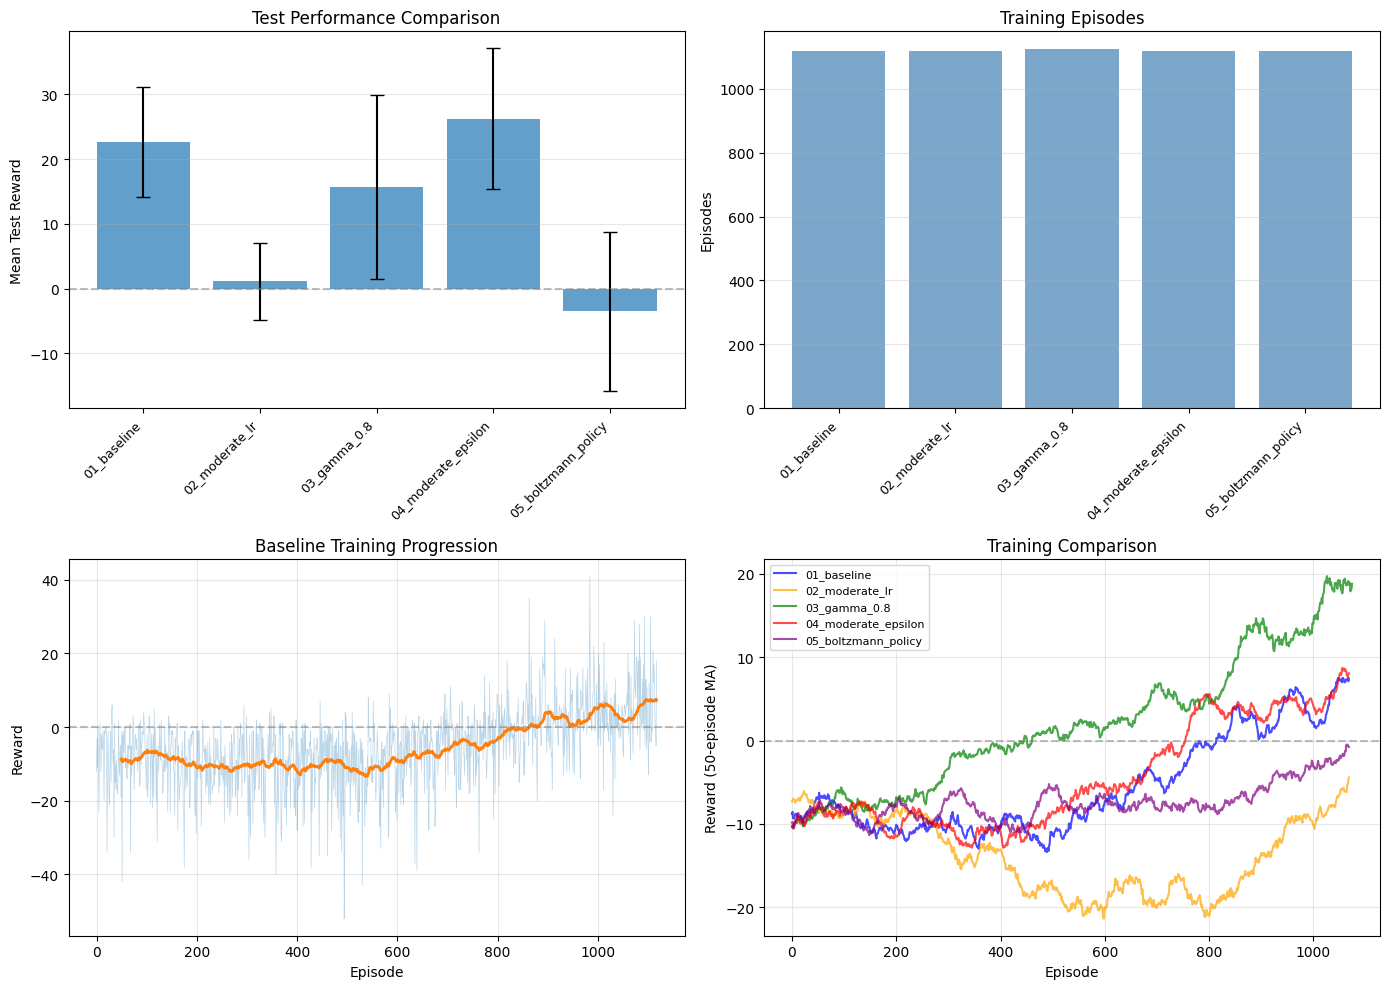

In [ ]:
if len(all_results) == 5:

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    names = [r['experiment'] for r in all_results]

    # Test performance comparison
    ax = axes[0, 0]
    rewards = [r['testing']['mean_reward'] for r in all_results]
    stds = [r['testing']['std_reward'] for r in all_results]
    ax.bar(range(len(names)), rewards, yerr=stds, capsize=5, alpha=0.7)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Mean Test Reward')
    ax.set_title('Test Performance Comparison')
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.grid(axis='y', alpha=0.3)

    # Training episodes
    ax = axes[0, 1]
    episodes = [r['training']['episodes'] for r in all_results]
    ax.bar(names, episodes, alpha=0.7, color='steelblue')
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Episodes')
    ax.set_title('Training Episodes')
    ax.grid(axis='y', alpha=0.3)

    # Baseline training curve
    ax = axes[1, 0]
    baseline = all_results[0]['training']['all_rewards']
    ax.plot(baseline, alpha=0.3, linewidth=0.5)
    if len(baseline) >= 50:
        ma = np.convolve(baseline, np.ones(50)/50, mode='valid')
        ax.plot(range(49, len(baseline)), ma, linewidth=2)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title('Baseline Training Progression')
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.grid(alpha=0.3)

    # All experiments comparison
    ax = axes[1, 1]
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    for i, r in enumerate(all_results):
        rews = r['training']['all_rewards']
        if len(rews) >= 50:
            ma = np.convolve(rews, np.ones(50)/50, mode='valid')
            ax.plot(ma, label=r['experiment'], color=colors[i], alpha=0.7, linewidth=1.5)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward (50-episode MA)')
    ax.set_title('Training Comparison')
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    plt.savefig(os.path.join(plots_dir, f'analysis_{timestamp}.png'), dpi=200, bbox_inches='tight')
    plt.show()

## Code Attribution and Citations

### Original Implementation

The following components were implemented originally for this assignment:
- Experiment design and configuration (5 experiments testing different hyperparameters)
- Training pipeline and workflow
- Multi-day training support with Google Drive persistence
- Comparative analysis and visualization code
- All experimental results and findings

### Adapted Code

**Custom Preprocessing Wrappers:**
- `AtariPreprocessing` class: Adapted from standard Atari preprocessing techniques
- `FrameStack` class: Adapted from standard frame stacking implementation
- Based on preprocessing pipeline described in Mnih et al. (2015)

**Episode Tracking:**
- `EpisodeTracker` class: Custom callback implementation using Stable-Baselines3 BaseCallback interface
- Original implementation for this assignment

**Boltzmann Policy:**
- `BoltzmannExplorationCallback` and `train_boltzmann_experiment`: Custom implementation
- Based on softmax action selection theory from reinforcement learning literature
- Integration approach adapted for Stable-Baselines3 compatibility

### Third-Party Libraries Used

**Core RL Framework:**
- **Stable-Baselines3** (v2.x): DQN implementation, training infrastructure
  - Raffin et al. (2021). "Stable-Baselines3: Reliable Reinforcement Learning Implementations"
  - License: MIT
  - Repository: https://github.com/DLR-RM/stable-baselines3

**Environment:**
- **Gymnasium** (v1.x): RL environment interface
  - License: MIT
  - Repository: https://github.com/Farama-Foundation/Gymnasium

**Atari Emulation:**
- **ALE (Arcade Learning Environment)**: Atari 2600 emulator
  - Bellemare et al. (2013). "The Arcade Learning Environment: An Evaluation Platform for General Agents"
  - License: GPL-2.0
  - Repository: https://github.com/Farama-Foundation/Arcade-Learning-Environment

**Utilities:**
- **OpenCV**: Image preprocessing (cv2.cvtColor, cv2.resize)
- **NumPy**: Numerical computations
- **Matplotlib**: Visualizations

### Academic References

**Deep Q-Learning:**
1. Mnih, V., Kavukcuoglu, K., Silver, D., et al. (2015). "Human-level control through deep reinforcement learning." *Nature*, 518(7540), 529-533.
2. Mnih, V., Kavukcuoglu, K., Silver, D., et al. (2013). "Playing Atari with Deep Reinforcement Learning." *arXiv preprint arXiv:1312.5602*.

**Atari Preprocessing:**
3. Machado, M. C., Bellemare, M. G., et al. (2018). "Revisiting the Arcade Learning Environment: Evaluation Protocols and Open Problems for General Agents." *Journal of Artificial Intelligence Research*, 61, 523-562.

**Exploration Strategies:**
4. Sutton, R. S., & Barto, A. G. (2018). *Reinforcement Learning: An Introduction* (2nd ed.). MIT Press.

### Referenced Repositories

The following repositories were consulted for understanding implementation approaches (no code directly copied):
- ykteh93/Deep_Reinforcement_Learning-Atari: Boxing implementation reference
- shubhlohiya/playing-atari-with-deep-RL: DQN structure understanding
- Stable-Baselines3 documentation and examples

# MIT License

Copyright (c) 2025 Tanvi Inchanalkar

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.